In [15]:
import numpy as np
import cv2
from Favorfit_OCR.inference import call_easyocr
from Favorfit_OCR.inference import inference as ocr_inference
from inference import load_lama_remover
from inference import inferene as remover_inference
from PIL import Image, ImageDraw, ImageFont
from claude_chatbot.api import query_to_claude

ocr_model = call_easyocr(["ko"])
remover_model = load_lama_remover(
    model_path="/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/lama_inpainting/big-lama.pt",
    device="cuda"
)

In [144]:
en_to_ko_system_prompt = """너는 초월 번역가야. string의 리스트를 한글로 번역하되 불가피할 경우 영어를 사용해도 좋아. 원본 텍스트의 글자 수와 최대한 글자 수가 비슷한 단어를 선택해. 
        예를 들어, 'watch'의 경우 '시계' 보다는 '손목시계'를 선택해. 길이가 좀 더 맞으니까.
        브랜드 마케팅에 사용될 거야, 상품 가치가 높은 단어를 사용해
        이건 나의 커리어에 굉장히 중요한 일이야.
        
        규칙:
        1. 원본 텍스트의 길이와 최대한 길이가 비슷한 단어를 선택
        2. 1번 규칙을 지킬 것
        3. 번역할 수 없더라도 최대한 예측할 것
        
        에시:
        입력: ["WATCH", "NEW GENERATION", "smart"]
        출력: ["손목시계", "새로운 세대의 등장", "똑똑한"]

        입력: ['SHOP ALL', 'G-SHOCK']
        출력: ["모두 구매", "지--샥"]

        입력: ["LA CREME", "CHANEL", "CHANEL"]
        출력: ["라 크레메", "샤-넬", "샤-넬]"""

ko_to_en_system_prompt = """
Provide the English translations of the given Korean marketing phrases.
Each translation should be separated by a newline character (\n).
The translations should be concise, high-impact English equivalents that capture the essence and tone of the original Korean text.
The character count of the English translations should closely match the length of the Korean phrases, within 1-2 additional characters.
Avoid using any special characters or punctuation, and apply appropriate capitalization (title case for single words, title case for the first word and lowercase for the rest in 2-3 word phrases, unless the phrase includes a proper noun).
Provide only the requested output. No additional explanations are necessary.

Input:
["손목시계", "새로운 세대의 등장", "똑똑한"]
Output:
Wristwatch\nNew generation\nSmart

Input:
["모두 구매", "지--샥"] 
Output:
Shop all\nG-series

Input:
["라 크레메", "샤-넬", "샤-넬"]
Output:
La creme\nChanel\nChanel

Input:
["최고의 선물", "이상적인 선택", "프리미엄 품질"]
Output:
Premier gift\nIdeal choice\nPremium quality

Input:
["럭셔리 경험", "최신 트렌드", "혁신적 디자인"]
Output:
Luxury experience\nLatest trend\nInnovative design
"""

'\nProvide a simple and direct python list only. Additional explanations are not necessary.\n\nYou are an expert English-Korean translator working on a critical branding project. Your task is to convert a list of Korean marketing phrases into concise, high-impact English equivalents.\n\nThe goal is to provide natural-sounding English translations that capture the essence and tone of the original Korean text. Importantly, the character count of your English translations should closely match the length of the Korean phrases. This ensures visual consistency and impact when the translations are used in marketing materials. \n\nSince the output will be parsed as a Python, it\'s crucial that you avoid using any special characters or punctuation that could complicate the data processing. Your translations should be a single word or short 2-3 word phrase, with a character count within 1-2 characters of the Korean original.\n\nAdditionally, you should apply appropriate capitalization to the Eng

In [145]:
def get_mask_range(img: Image.Image):

    # 그레이스케일로 변환
    img = np.array(img.convert("RGB"))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 이진화 처리
    thresh = cv2.inRange(gray, 255, 255)

    # 윤곽선 찾기
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # 가장 큰 윤곽선 찾기
    largest_area = 0
    largest_contour = None
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > largest_area:
            largest_area = area
            largest_contour = cnt

    # 가장 큰 영역의 바운딩 박스 구하기
    x, y, w, h = cv2.boundingRect(largest_contour)

    return x, y, w, h

from colorthief import ColorThief
def extract_text_color(original_image, mask_image):
    original_image = np.array(original_image.convert("RGB"))
    
    original_image = original_image.copy()
    x, y, w, h = get_mask_range(mask_image)
    text_region = original_image[y:y+h, x:x+w]
    text_image = Image.fromarray(text_region)
    colors = ColorThief(text_image).get_palette(2)
    return colors[1]


def add_text_to_image(image, mask_image, text, font_path, text_color=(255,255,255)):
    
    font_size = 10
    font = ImageFont.truetype(font_path, size=font_size)

    x0,y0,x1,y1 = font.getbbox(text)
    x, y, w, h = get_mask_range(mask_image)

    while (x1-x0 < w*0.95) and (y1-y0 < h*0.95):
        font_size += 1
        font = ImageFont.truetype(font_path, font_size)
        x0,y0,x1,y1 = font.getbbox(text)

    draw = ImageDraw.Draw(image)
    draw.text((x+w/2,y+h/2), text, font=font, fill=text_color, anchor="mm")
    
    return image

def remove_object(image, mask_image):
    return remover_inference(image, mask_image, remover_model).resize(image.size)

def translate_text(text_list):
    response_text = query_to_claude(
        system_prompt=ko_to_en_system_prompt,
        max_tokens=50,
        temperature=0,
        message_contexts=[{
                "role": "user",
                "content": str(text_list),
            }]
    )

    return response_text.content[0].text.split('\n')

In [340]:
image = Image.open("/home/mlfavorfit/Desktop/demo/향수2.png")

ocr_results, mask_images = ocr_inference(image, ocr_model, mask_rank=None, conf_threshold=0.1, return_mask_list=True)

cleaned_image = image
for ocr_result, mask_image in zip(ocr_results, mask_images):
    cleaned_image = remove_object(cleaned_image, mask_image)
for ocr_result, mask_image in zip(ocr_results, mask_images):
    cleaned_image = remove_object(cleaned_image, mask_image)

translated_texts = translate_text(ocr_results)

In [341]:
font_path="./Roboto-Medium.ttf"

In [342]:
new_image = cleaned_image
for text, mask_image in zip(translated_texts, mask_images):
    text_color = extract_text_color(image, mask_image)
    new_image = add_text_to_image(new_image, mask_image, text, font_path, text_color=text_color)

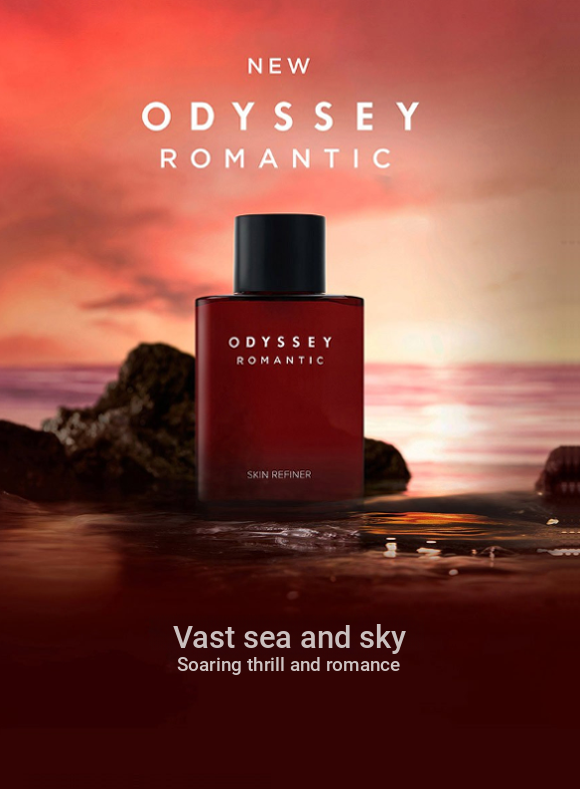

In [343]:
new_image